In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU,LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=3).mean()
    # data['SMA100'] = data['Close'].rolling(window=5).mean()
    vol_window = 3
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
        # LSTM(200, return_sequences=False, input_shape=input_shape),  # LSTM layer
        # LeakyReLU(),  # Apply Leaky ReLU to LSTM outputs
        LSTM(200, activation='relu', return_sequences=False),  # LSTM layer
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    pred_count = 0
    red_x,red_y, black_y, blue_x, blue_y, green_y = [],[],[],[],[],[]
    for idx in range(0,s.shape[0], pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 1))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 1))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label
        if idx< cut_off:
            red_x +=[idx]
            red_y+=[future_transform]
            black_y+=[future_true_transform]
        else:
            blue_x +=[idx]
            blue_y+=[future_transform]
            green_y+=[future_true_transform]

        # # Plot the predictions
        # plt.scatter(idx, future_transform, 
        # # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        #     color="red" if idx < cut_off else "blue")


        # # plt.plot(np.arange(idx, idx + pred_len), future_transform, 
        # #         # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        # #          color="red" if idx < cut_off else "blue")

        # # Plot the true values
        # plt.scatter(idx, future_true_transform, 
        #          #label="Train True" if idx < cut_off else "Test True", 
        #          color="black" if idx < cut_off else "green")

        
        if idx >= cut_off:
            pred_count+=1
    plt.plot(red_x, red_y, color = "red")
    plt.plot(red_x, black_y, color = "black")
    plt.plot(blue_x, blue_y, color = "blue")
    plt.plot(blue_x, green_y, color = "green")
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    # for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        # plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    # for i, rmse in zip(section_start_idx, rmse_values):
    #     plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    # plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    # print(rmse_values)
    # plt.grid(True)
    if m == "LSTM w/ 1 feature":
        dir = f"{seq_len}-{pred_len}/lstm_1"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 1 feature"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2024-11-03", end_date="2024-12-02")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        # tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close']#, 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # # Step 5: Perform Hankel Matrix Decomposition
        # window_size = 50  # Size of the sliding window to form the Hankel matrix
        # hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # # Step 6: Perform SVD on the Hankel matrix
        # U, Sigma, Vt = hankel_svd(hankel_matrix)

        # # You can choose the first few singular values and modes to add as features
        # num_modes = 2  # Number of modes to add as features
        # dmd_modes = U[:, :num_modes]  # Select the modes
        # dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # # Trim the processed_data to match the number of rows in dmd_modes
        # processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # # Combine the Hankel decomposition modes with the processed data
        # data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 1 # 6 months of data
        pred_len = 1  # Predict the next 20 days
        sequences = create_sequences(processed_data, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.8 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, processed_data, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

2024-12-03 17:06:52.456394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 17:07:04.135267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733267228.012938   22961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733267228.593149   22961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 17:07:10.947335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[*********************100%***********************]  1 of 1 completed
2024-12-03 17:07:24.403542: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(15, 2, 1)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5123
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4455
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3712
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2860
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1932
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1051
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0466
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0568
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1193
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1323
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1007
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0639
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0433
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0409
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0491
Epoch 16/1

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5252
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.4568
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3880
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3090
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2220
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1363
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0719
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0629
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1197
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1488
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1260
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0887
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0637
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0577
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0649
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2923
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2521
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2126
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1685
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1220
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0802
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0576
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0724
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0999
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0984
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0794
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0623
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0553
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0573
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0632
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2415
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2111
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1791
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1434
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1065
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0751
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0623
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0804
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0978
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0915
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0760
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0647
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0618
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0650
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0699
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2249
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1971
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1672
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1340
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0718
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0614
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0787
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0930
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0865
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0723
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0619
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0587
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0607
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0645
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2878
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2505
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2124
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1706
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1263
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0851
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0590
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0652
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0939
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0996
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0848
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0676
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0582
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0573
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0615
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3417
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2975
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2507
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1978
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1406
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0879
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0574
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0722
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1060
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1049
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0811
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0589
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0492
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0510
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0578
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1707
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1432
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1159
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0862
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0566
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0332
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0272
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0448
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0545
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0470
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0351
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0277
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0266
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0295
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0331
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2394
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2053
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1692
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1301
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0924
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0658
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0668
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0918
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0964
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0828
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0683
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0617
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0629
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0678
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0721
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(15, 2, 1)
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2439
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2077
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1693
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1266
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0821
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0437
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0266
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0469
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0675
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0610
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0434
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0299
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0249
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0264
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0305
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

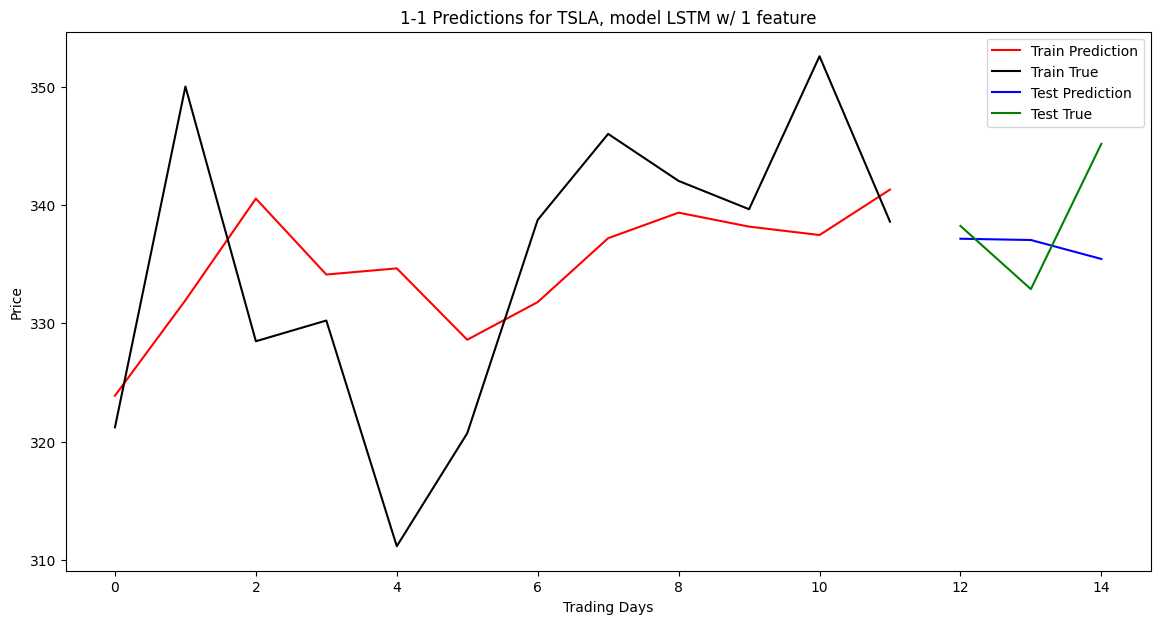

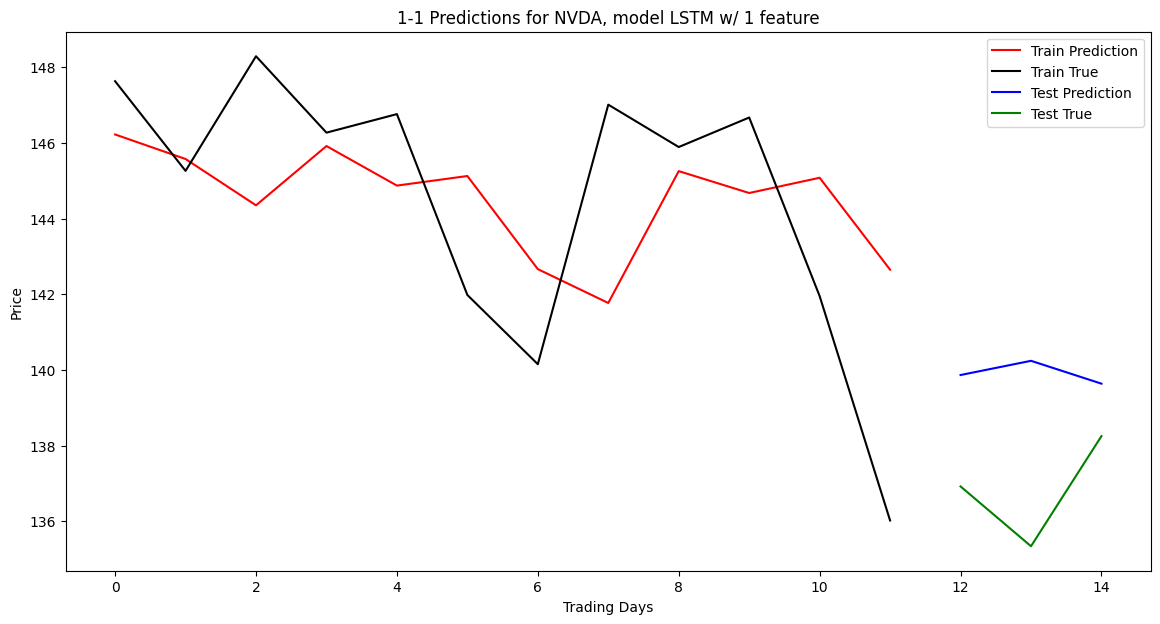

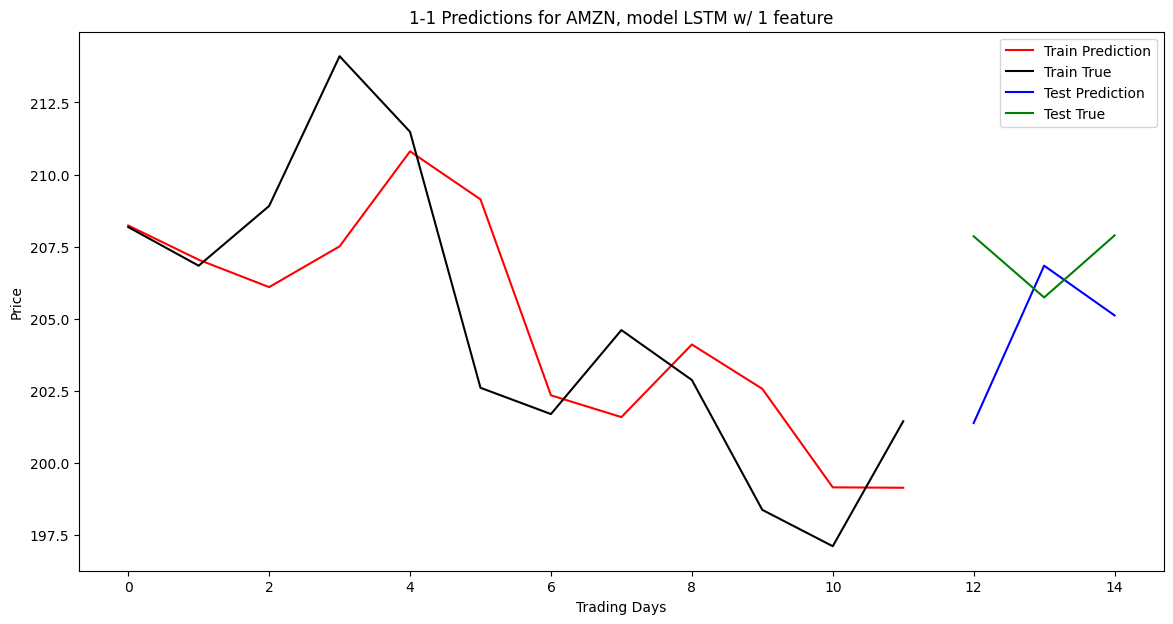

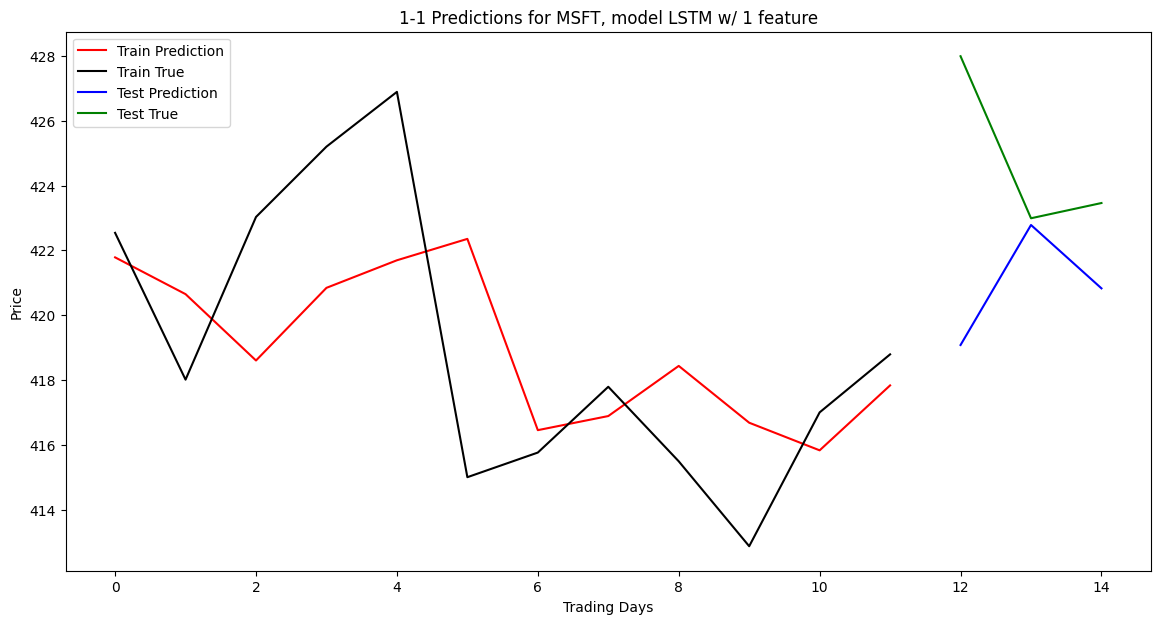

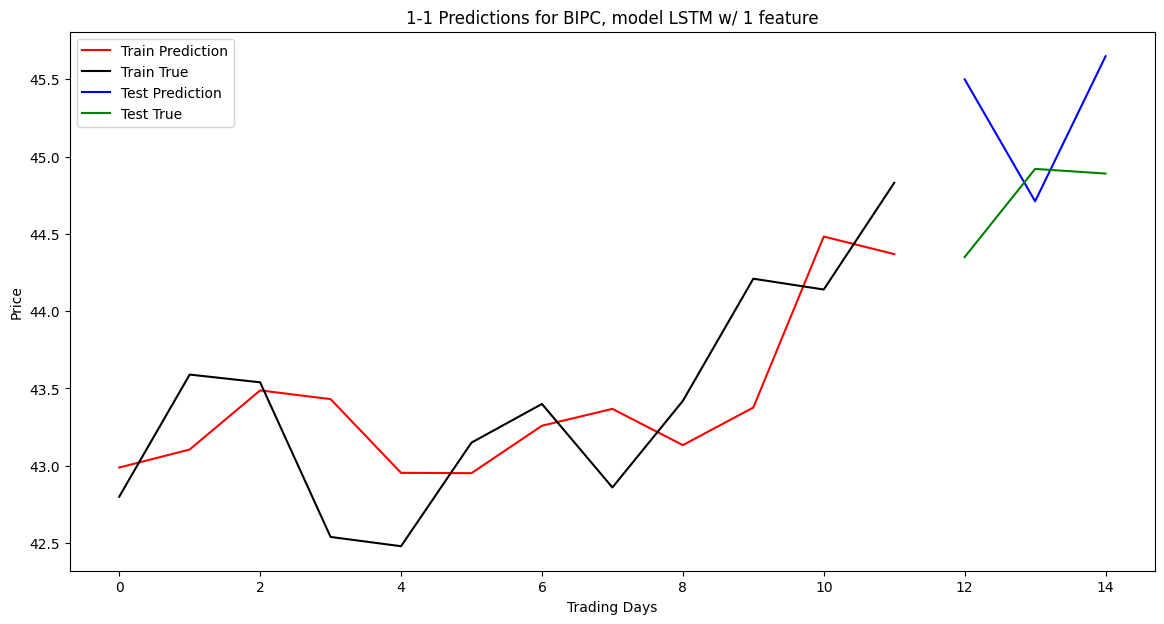

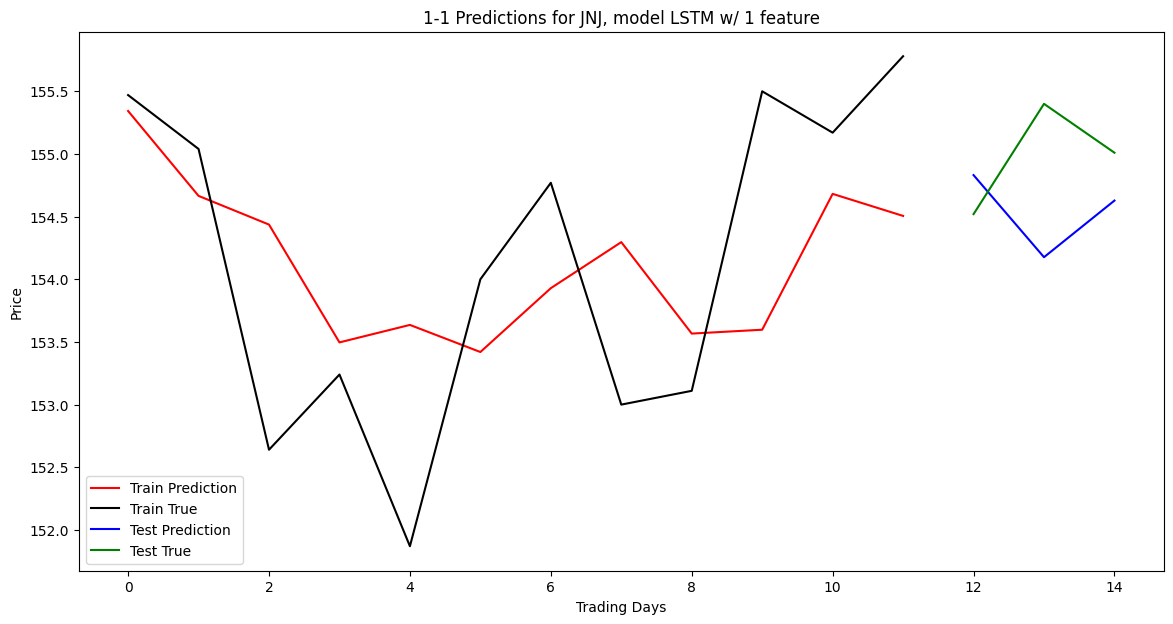

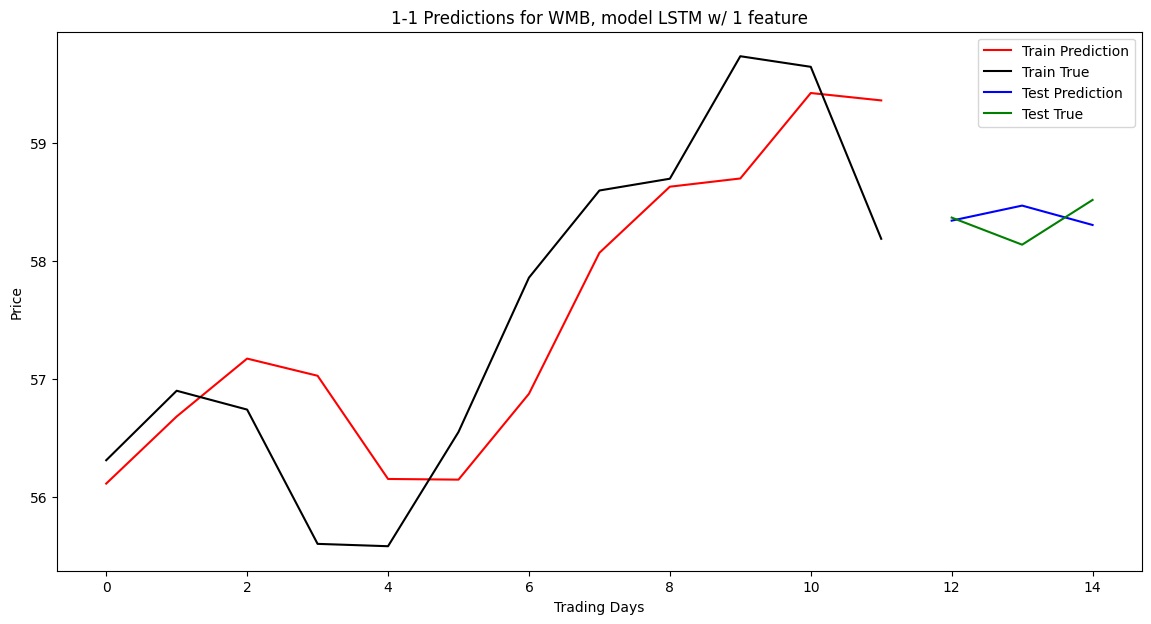

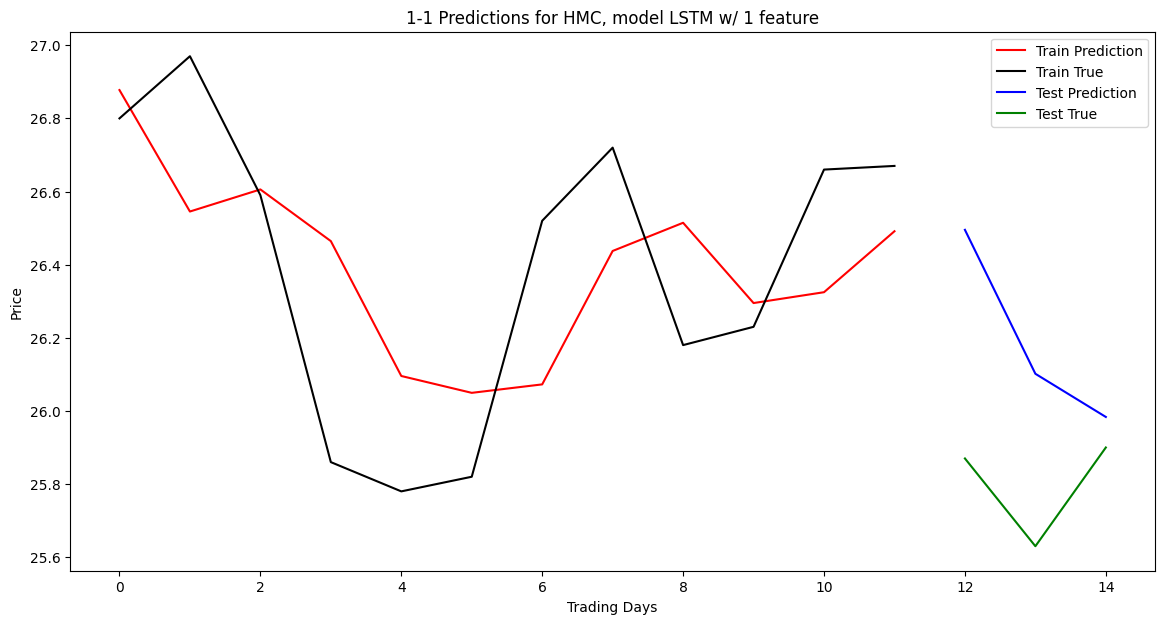

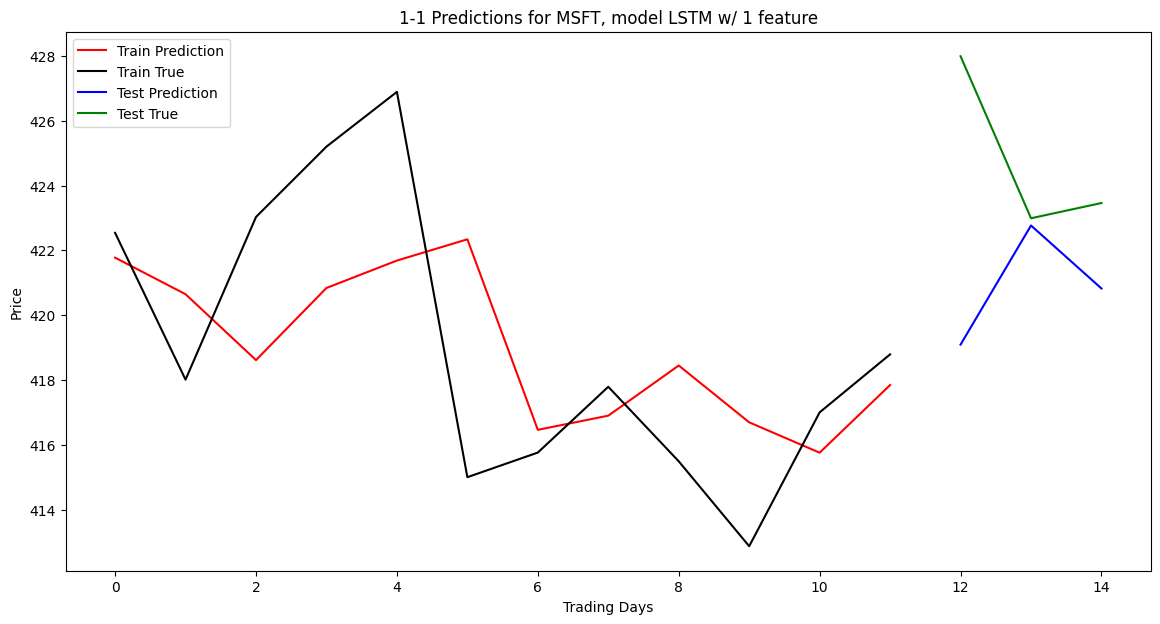

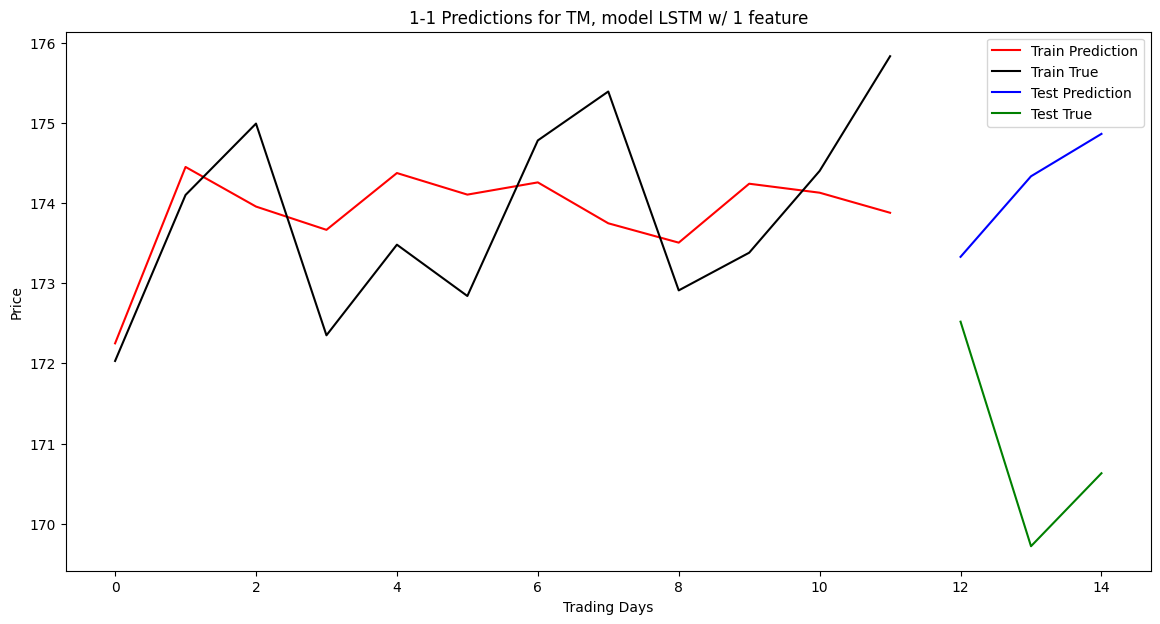

In [2]:
tickers = ["TSLA", "NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"] # 
mse = main(tickers)

In [3]:
mse

1.1499396717011436